piece_dir: /Users/toddywang/Documents/VsCodeProjects/xmltoexp/ATEPP-1.2/ATEPP-1.2/Franz_Liszt/Mephisto_Waltz_No._1,_S.514
score_path: /Users/toddywang/Documents/VsCodeProjects/xmltoexp/ATEPP-1.2/ATEPP-1.2/Franz_Liszt/Mephisto_Waltz_No._1,_S.514/musicxml_cleaned.musicxml
found match files: 20
Metadata: ScoreMetadata(composer=None, genre=None, major_time_sig='3/8', year=None, title='Mephisto Waltz No. 1 S. 514')
Notes: 10240, Expressions: 754

[SCORE BEAT GRID]
score_beat_start: 1.5
score_beat_end  : 1456.9854166666667
score_shift     : 1 (so beat_idx = floor(score_beat)-score_shift)
score_total_beats: 1456

First 5 score notes:


,pitch,duration,position,part_id,tie,is_staccato,is_accent,fingering,xml_note_id
0,E#3,0.0,13.5,P1-Staff1,None,False,False,None,None
1,F#3,0.5,13.5,P1-Staff1,None,False,True,None,None
2,F#3,0.5,14.0,P1-Staff1,None,False,False,None,None
3,F#3,0.5,14.5,P1-Staff1,None,False,False,None,None
4,F#3,0.5,15.0,P1-Staff1,None,False,False,None,None



[TEMPO ARRAYS]
built: 20 failed: 0
unique lengths: {1456}  (expected {score_total_beats} )
10456_match.txt: len=1456 BPM min/med/max=28.0/188.5/600.0
10457_match.txt: len=1456 BPM min/med/max=13.3/150.9/401.3
10458_match.txt: len=1456 BPM min/med/max=27.4/155.6/403.9
10459_match.txt: len=1456 BPM min/med/max=16.3/152.9/576.0
10460_match.txt: len=1456 BPM min/med/max=32.0/155.4/600.0
... (showing first 5 only)


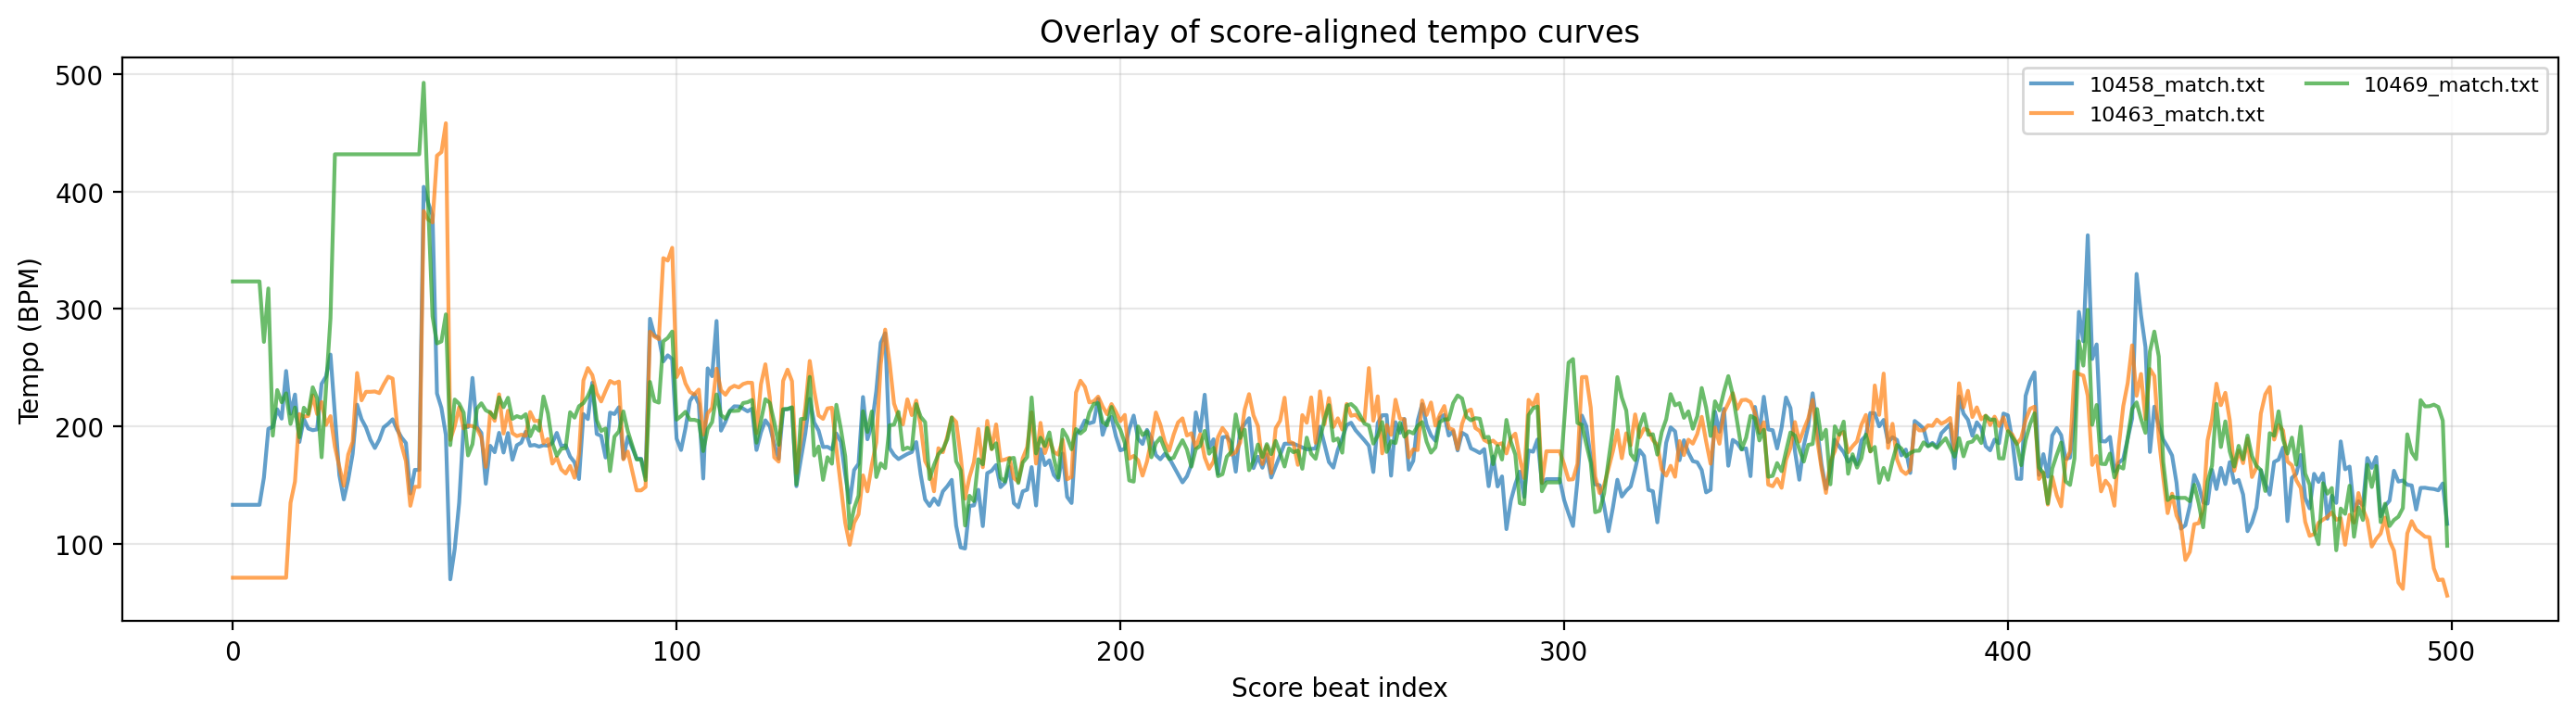

In [5]:
# =========================
# FULL NOTEBOOK: score-aligned beat tempo curves from match files
# (beat index = floor(score_beat) aligned to the same score beat positions)
# =========================

from pathlib import Path
import sys
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import asdict

# -------------------------
# 0) PATHS
# -------------------------
repo_root = Path("/Users/toddywang/Documents/VsCodeProjects/xmltoexp")
piece_dir = repo_root / "ATEPP-1.2/ATEPP-1.2/Franz_Liszt/Mephisto_Waltz_No._1,_S.514"
fmt3x = piece_dir / "score_fmt3x.txt"

# match files
match_files = sorted(
    p for p in piece_dir.glob("*_match.txt")
    if not p.stem.endswith(("_pre_match", "_err_match"))
)

# score (MusicXML)
tok_root = repo_root / "MERIX SUBMISSION/MIREX_Model/MIREX_Tokenizer"
sys.path.insert(0, str(tok_root))
score_path = piece_dir / "musicxml_cleaned.musicxml"

print("piece_dir:", piece_dir)
print("score_path:", score_path)
print("found match files:", len(match_files))


# -------------------------
# 1) PARSE SCORE -> COMPUTE SCORE BEAT GRID LENGTH
# -------------------------
from tokenizer.score_tokenizer import MusicXMLTokenizer

tok = MusicXMLTokenizer(str(score_path))
score_notes = tok.tokenize_notes()
score_exprs = tok.parse_expressions()
score_meta  = tok.parse_metadata()

df_notes = pd.DataFrame([asdict(n) for n in score_notes])
df_exprs = pd.DataFrame([asdict(e) for e in score_exprs]) if score_exprs else pd.DataFrame()

print("Metadata:", score_meta)
print(f"Notes: {len(df_notes)}, Expressions: {len(df_exprs)}")

# Compute score beat span from note positions/durations
pos = df_notes["position"].astype(float).to_numpy()
dur = df_notes["duration"].astype(float).to_numpy()
end_pos = pos + dur

score_beat_start = float(np.min(pos))
score_beat_end   = float(np.max(end_pos))

# shift so that score beat indices start at 0
score_shift = int(np.floor(score_beat_start))
score_total_beats = int(np.ceil(score_beat_end - score_shift))

print("\n[SCORE BEAT GRID]")
print("score_beat_start:", score_beat_start)
print("score_beat_end  :", score_beat_end)
print("score_shift     :", score_shift, "(so beat_idx = floor(score_beat)-score_shift)")
print("score_total_beats:", score_total_beats)

# Optional quick preview
print("\nFirst 5 score notes:")
display(df_notes.head())


# -------------------------
# 2) MATCH -> SCORE-ALIGNED BPM CURVE (1 value per score beat index)
# -------------------------
def read_tpqn(fmt3x_path: Path, default: float = 24.0) -> float:
    m = re.search(r"TPQN:\s*(\d+)", fmt3x_path.read_text())
    return float(m.group(1)) if m else default


def bpm_curve_aligned_to_score(
    match_path: Path,
    fmt3x_path: Path,
    score_total_beats: int,
    score_shift: int,
    bpm_range=(0, 5000),
    smooth_window=3,
):
    """
    Build a score-aligned tempo array:
      - beat index uses floor(score_beat) and then shifts to 0-based score beat grid
      - output length = score_total_beats
      - tempo[k] corresponds to score beat k (same k across all performances)
    """
    tpqn = read_tpqn(fmt3x_path, default=24.0)

    rows = []
    for ln in match_path.read_text().splitlines():
        if not ln.strip() or ln.startswith("//") or ln.startswith("Missing"):
            continue
        parts = re.split(r"\s+", ln.strip())
        if len(parts) < 12:
            continue
        rows.append({
            "onset": float(parts[1]),
            "score_time": float(parts[8]),
            "score_note": parts[9],
            "err_idx": parts[10],
        })
    if not rows:
        return None

    df = pd.DataFrame(rows)
    df = df[(df["score_note"] != "*") & (df["err_idx"] == "0")]
    if df.empty:
        return None

    df["score_beat"] = df["score_time"] / tpqn

    # ✅ floor + shift to align to score beat positions
    df["beat_idx"] = np.floor(df["score_beat"]).astype(int) - int(score_shift)

    # keep only beats within score grid
    df = df[(df["beat_idx"] >= 0) & (df["beat_idx"] < score_total_beats)]
    if df.empty:
        return None

    # representative onset time per beat
    beat_time = df.groupby("beat_idx")["onset"].median().sort_index()

    # reindex to full score beat grid
    full_idx = pd.Index(range(score_total_beats), name="beat_idx")
    beat_time = beat_time.reindex(full_idx)

    # fill missing beat times
    beat_time = beat_time.interpolate("linear", limit_direction="both")

    # compute tempo as 60/dt
    dt = beat_time.diff()
    tempo = 60.0 / dt  # tempo[0] will be NaN

    # bpm range filter
    lo, hi = bpm_range
    tempo = tempo[(tempo > lo) & (tempo < hi)]

    # smooth and clip
    tempo = tempo.rolling(window=smooth_window, center=True, min_periods=1).mean()
    tempo = tempo.clip(upper=600)

    # ensure full length (score_total_beats), fill remaining gaps
    tempo = tempo.reindex(range(score_total_beats))
    tempo = tempo.interpolate("linear", limit_direction="both")

    arr = tempo.to_numpy()
    return arr


# -------------------------
# 3) BUILD tempo_arrays: dict[name -> np.ndarray], all with length score_total_beats
# -------------------------
tempo_arrays = {}
failed = []

for mf in match_files:
    arr = bpm_curve_aligned_to_score(
        mf, fmt3x,
        score_total_beats=score_total_beats,
        score_shift=score_shift,
        bpm_range=(0, 5000),
        smooth_window=3
    )
    if arr is None or len(arr) == 0:
        failed.append(mf.name)
        continue

    # force exact length
    if len(arr) != score_total_beats:
        if len(arr) > score_total_beats:
            arr = arr[:score_total_beats]
        else:
            arr = np.pad(arr, (0, score_total_beats - len(arr)), mode="edge")

    tempo_arrays[mf.name] = arr

print("\n[TEMPO ARRAYS]")
print("built:", len(tempo_arrays), "failed:", len(failed))
if failed:
    print("failed (first 10):", failed[:10])

# length sanity check
lengths = set(len(v) for v in tempo_arrays.values())
print("unique lengths:", lengths, " (expected {score_total_beats} )")


# -------------------------
# 4) OPTIONAL: PRINT STATS PER PERFORMANCE
# -------------------------
for name, arr in list(tempo_arrays.items())[:5]:
    print(f"{name}: len={len(arr)} BPM min/med/max="
          f"{np.nanmin(arr):.1f}/{np.nanmedian(arr):.1f}/{np.nanmax(arr):.1f}")
print("... (showing first 5 only)")


# -------------------------
# 5) OPTIONAL: VISUAL CHECK (random n overlays)
# -------------------------
def plot_overlay_tempos(names=None, n=3, max_beats=None):
    if not tempo_arrays:
        print("tempo_arrays is empty.")
        return

    all_names = list(tempo_arrays.keys())
    if names is None:
        n = min(n, len(all_names))
        names = random.sample(all_names, n)
    else:
        names = [nm for nm in names if nm in tempo_arrays]

    plt.figure(figsize=(14, 4))
    for nm in names:
        curve = tempo_arrays[nm]
        if max_beats is not None:
            curve = curve[:max_beats]
        plt.plot(curve, alpha=0.7, label=nm)
    plt.xlabel("Score beat index")
    plt.ylabel("Tempo (BPM)")
    plt.title("Overlay of score-aligned tempo curves")
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()


plot_overlay_tempos(n=3, max_beats=500)


# -------------------------
# 6) (OPTIONAL) SAVE FOR LATER
# -------------------------
# np.savez(piece_dir / "tempo_arrays_score_aligned.npz", **tempo_arrays)
# print("Saved:", piece_dir / "tempo_arrays_score_aligned.npz")


匹配文件数: 20


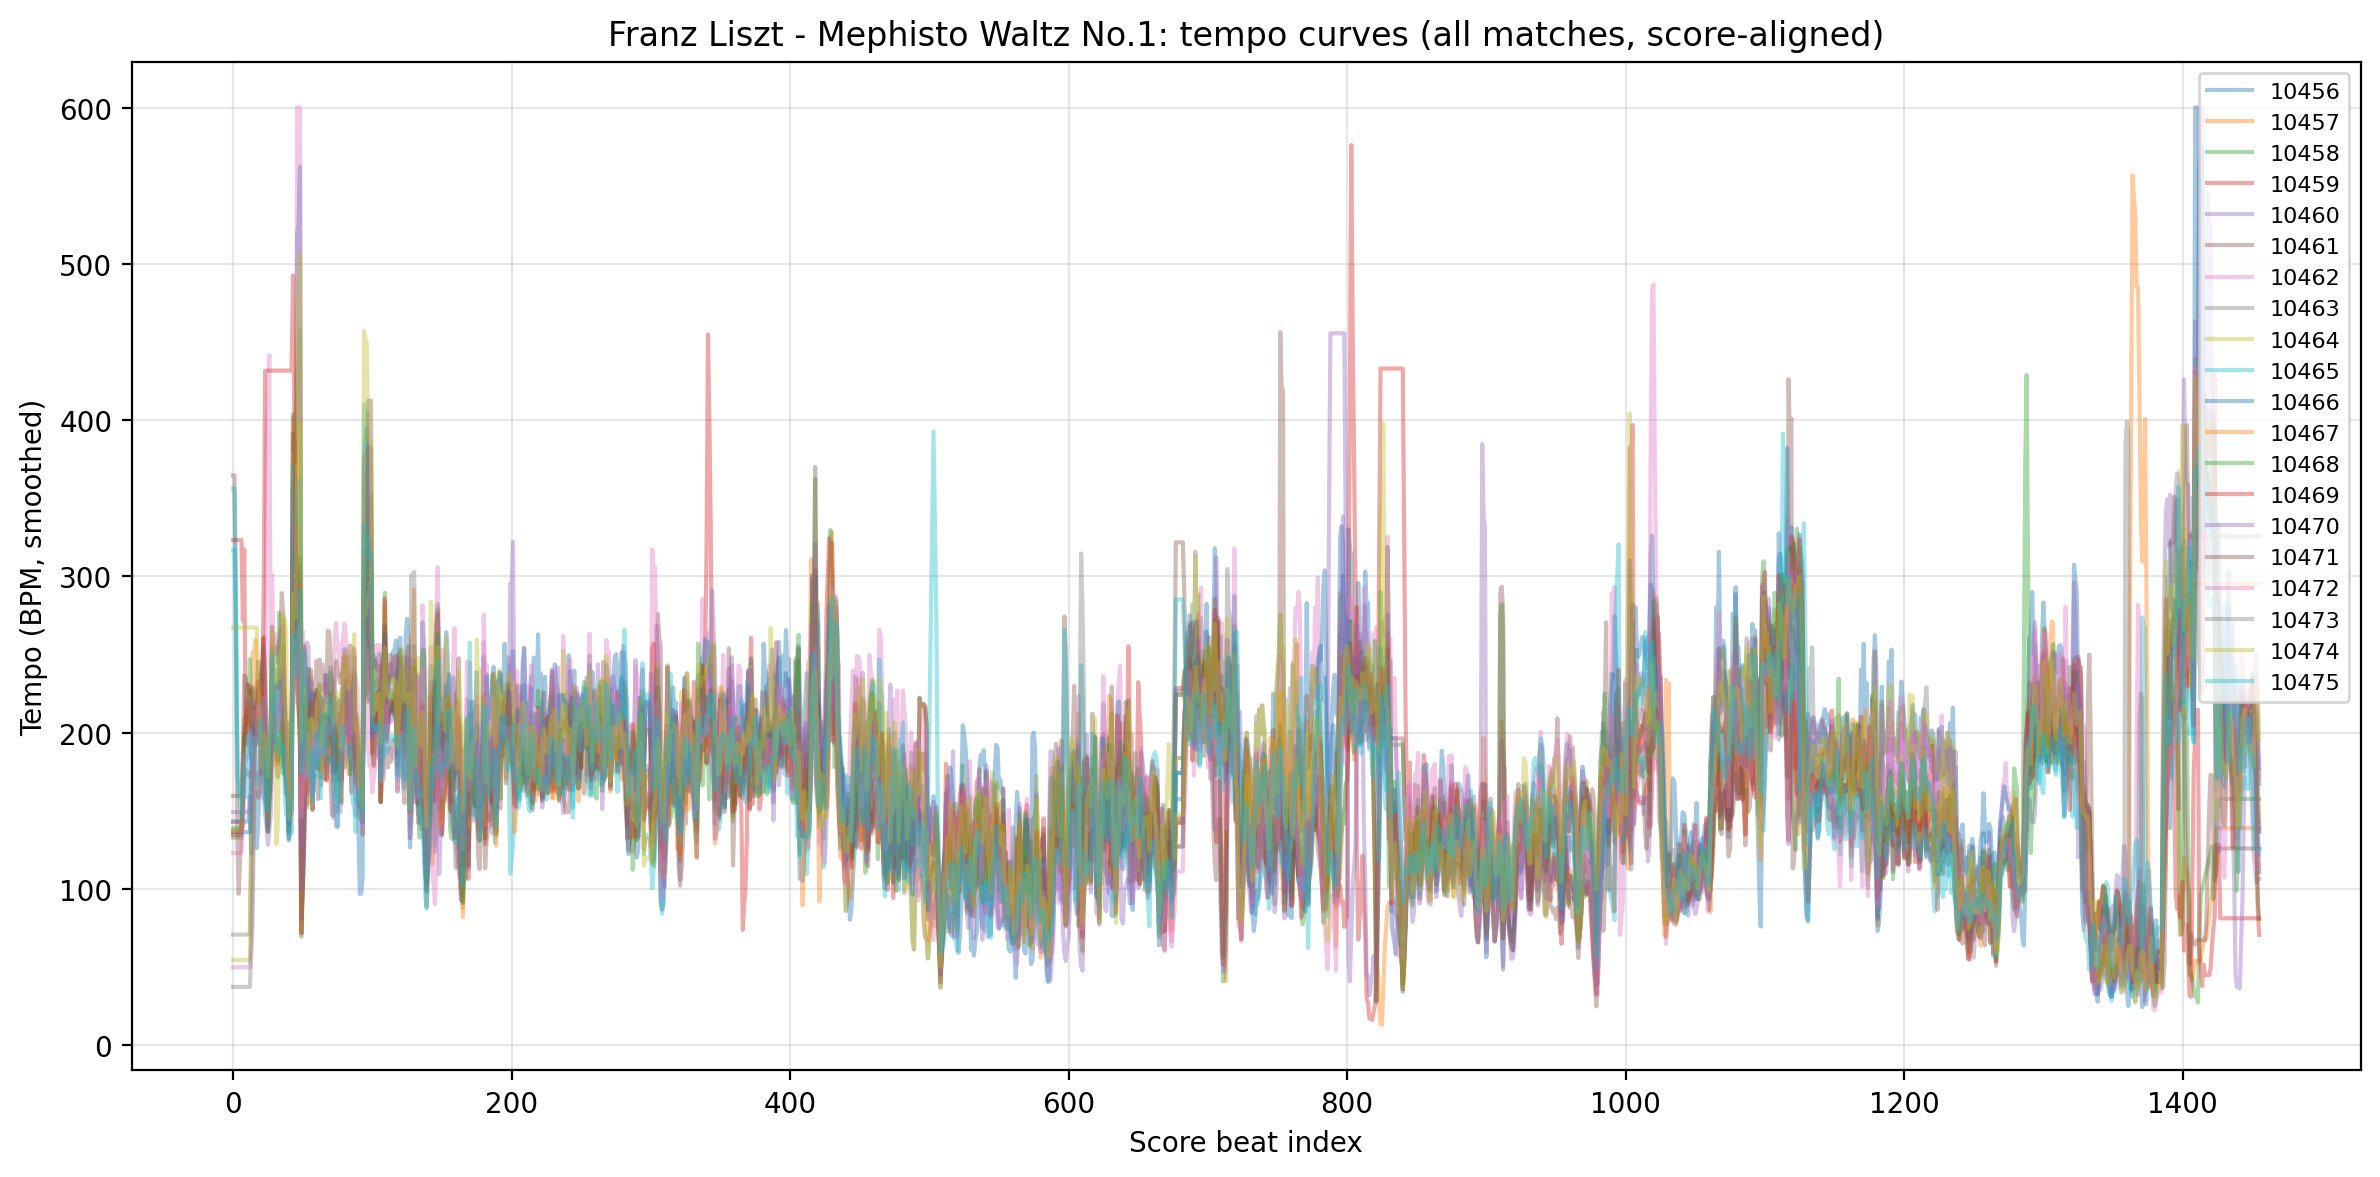

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 你的 tempo_arrays 现在是 dict[name -> np.ndarray]（score-aligned, 等长）
print(f"匹配文件数: {len(tempo_arrays)}")

plt.figure(figsize=(12, 6))

for name, tempo in tempo_arrays.items():
    # tempo: np.ndarray，位置顺序已与 score 的 beat 对齐
    beats = np.arange(len(tempo))
    vals = tempo
    plt.plot(beats, vals, label=name.replace("_match.txt", ""), alpha=0.4)

plt.xlabel("Score beat index")
plt.ylabel("Tempo (BPM, smoothed)")
plt.title("Franz Liszt - Mephisto Waltz No.1: tempo curves (all matches, score-aligned)")
plt.legend(loc="upper right", fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


10456_match.txt: len=1456, 检测到 98 个断句
10457_match.txt: len=1456, 检测到 105 个断句
10458_match.txt: len=1456, 检测到 93 个断句
10459_match.txt: len=1456, 检测到 96 个断句
10460_match.txt: len=1456, 检测到 97 个断句
10461_match.txt: len=1456, 检测到 100 个断句
10462_match.txt: len=1456, 检测到 100 个断句
10463_match.txt: len=1456, 检测到 88 个断句
10464_match.txt: len=1456, 检测到 90 个断句
10465_match.txt: len=1456, 检测到 96 个断句
10466_match.txt: len=1456, 检测到 88 个断句
10467_match.txt: len=1456, 检测到 90 个断句
10468_match.txt: len=1456, 检测到 97 个断句
10469_match.txt: len=1456, 检测到 98 个断句
10470_match.txt: len=1456, 检测到 99 个断句
10471_match.txt: len=1456, 检测到 94 个断句
10472_match.txt: len=1456, 检测到 96 个断句
10473_match.txt: len=1456, 检测到 92 个断句
10474_match.txt: len=1456, 检测到 96 个断句
10475_match.txt: len=1456, 检测到 87 个断句


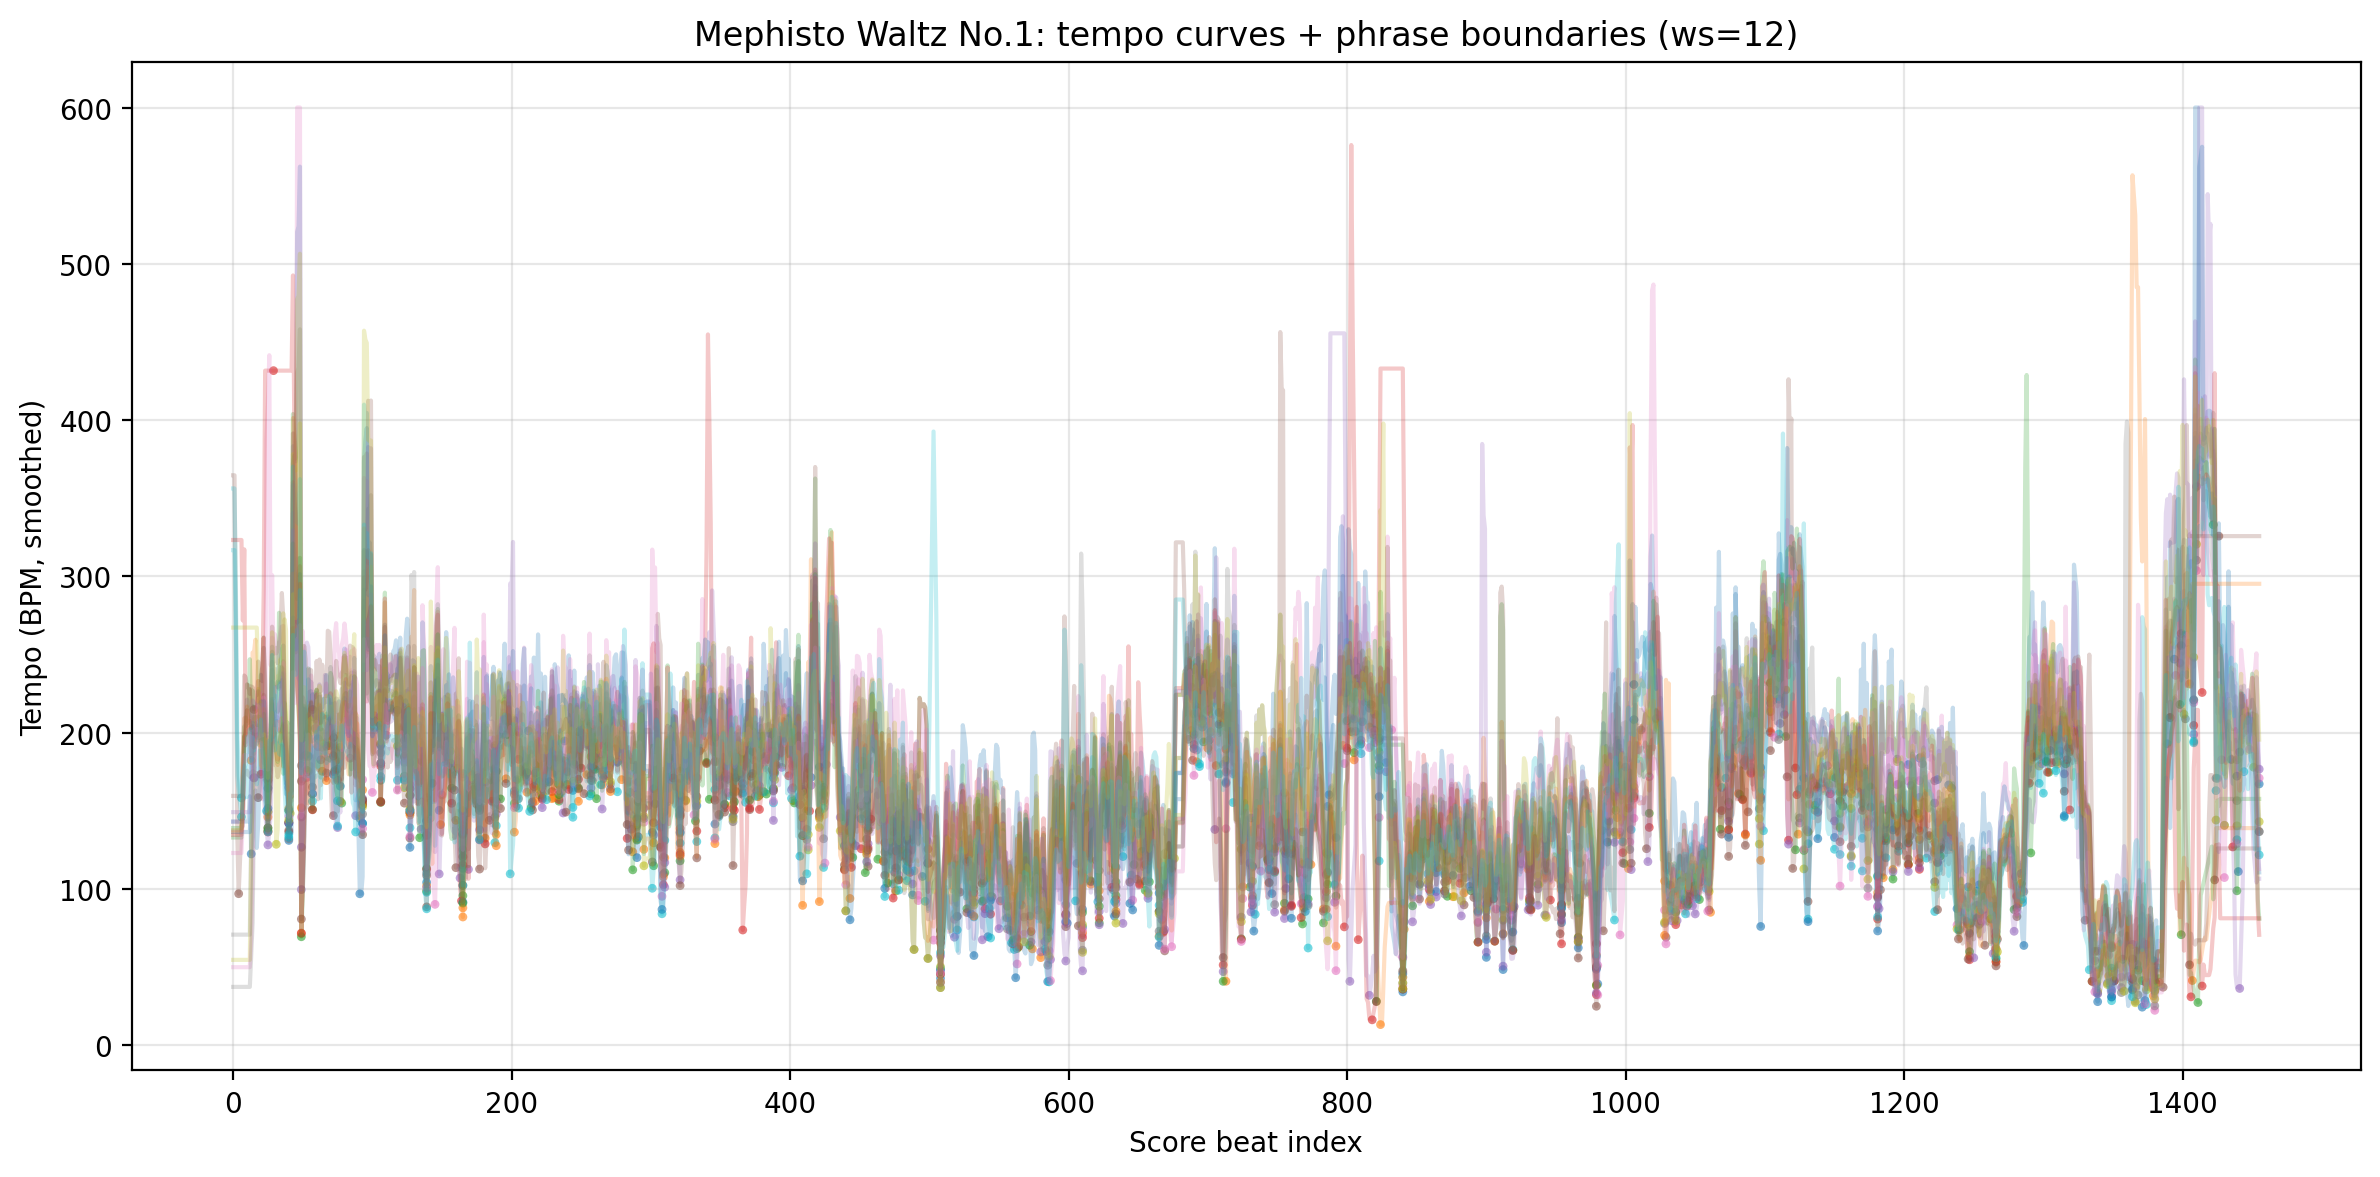

In [8]:
# =========================
# 计算断句 + 在一张图上展示（tempo 曲线 + 断句位置）
# 适配你现在的 tempo_arrays: dict[name -> np.ndarray]（score-aligned）
# =========================

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def group_analysis_new(tempo_curve, ws, plot=False, return_pro=False):
    tempo = np.asarray(tempo_curve, dtype=float)
    n = len(tempo)
    ws = int(ws)
    if ws <= 1 or n == 0:
        return np.array([], dtype=int) if not return_pro else (np.array([], dtype=int), tempo * 0)

    # 1) sliding RMS (zero padding to keep same length)
    if ws % 2 == 1:
        pad_left = (ws - 1) // 2
        pad_right = ws - 1 - pad_left
    else:
        pad_left = ws // 2
        pad_right = ws - pad_left

    padded = np.pad(tempo, (pad_left, pad_right), mode="constant", constant_values=0.0)
    pro = np.zeros(n, dtype=float)

    for i in range(n):
        window = padded[i:i + ws]
        nonzero = window != 0
        if np.any(nonzero):
            pro[i] = np.sqrt(np.sum(window[nonzero] ** 2) / nonzero.sum())
        else:
            pro[i] = 0.0

    # 2) find valleys on pro by finding peaks on -pro
    min_width = int(np.ceil(ws / 2))
    peaks, _ = find_peaks(-pro, distance=min_width)

    if len(peaks) == 0:
        return np.array([], dtype=int) if not return_pro else (np.array([], dtype=int), pro)

    # 3) refine: local minimum on original tempo within +/- half window
    locs = []
    half = (ws - 1) // 2 if (ws % 2 == 1) else ws // 2
    for p in peaks:
        left = max(0, p - half)
        right = min(n - 1, p + half)
        segment = tempo[left:right + 1]
        if segment.size == 0:
            continue
        locs.append(left + int(np.argmin(segment)))

    locs = np.array(sorted(set(locs)), dtype=int)

    # optional plot for a single curve
    if plot:
        fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
        axes[0].plot(pro, label="RMS (pro)")
        axes[0].set_ylabel("RMS")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(tempo, label="tempo")
        axes[1].stem(locs, tempo[locs], linefmt="C1-", markerfmt="C1o",
                     basefmt=" ", label="boundaries")
        axes[1].set_xlabel("Score beat index")
        axes[1].set_ylabel("Tempo")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return (locs, pro) if return_pro else locs


def boundaries_to_mask(n_beats, boundary_indices):
    mask = np.zeros(n_beats, dtype=int)
    boundary_indices = np.asarray(boundary_indices, dtype=int)
    boundary_indices = boundary_indices[(boundary_indices >= 0) & (boundary_indices < n_beats)]
    mask[boundary_indices] = 1
    return mask


# -------------------------
# A) 计算每个演奏的断句（mask / locs）
# -------------------------
ws = 12  # 你可以调：8/12/16...

boundary_locs_dict = {}   # name -> np.ndarray of boundary beat indices
boundary_masks_dict = {}  # name -> 0/1 mask length = score_total_beats

for name, curve in tempo_arrays.items():
    locs, pro = group_analysis_new(curve, ws=ws, plot=False, return_pro=True)
    mask = boundaries_to_mask(len(curve), locs)
    boundary_locs_dict[name] = locs
    boundary_masks_dict[name] = mask
    print(f"{name}: len={len(curve)}, 检测到 {len(locs)} 个断句")


# -------------------------
# B) 展示：一张图叠加所有 tempo 曲线 + 断句点（同色标记）
# -------------------------
plt.figure(figsize=(12, 6))

for name, tempo in tempo_arrays.items():
    beats = np.arange(len(tempo))
    vals = tempo
    line, = plt.plot(beats, vals, label=name.replace("_match.txt", ""), alpha=0.25)

    locs = boundary_locs_dict.get(name, np.array([], dtype=int))
    if len(locs) > 0:
        # 用同色 scatter 标断句
        plt.scatter(locs, vals[locs], s=10, alpha=0.6, color=line.get_color(), edgecolors="none")

plt.xlabel("Score beat index")
plt.ylabel("Tempo (BPM, smoothed)")
plt.title(f"Mephisto Waltz No.1: tempo curves + phrase boundaries (ws={ws})")
plt.grid(True, alpha=0.3)

# 图例太多会挤爆：建议不显示或只显示前几个
# plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

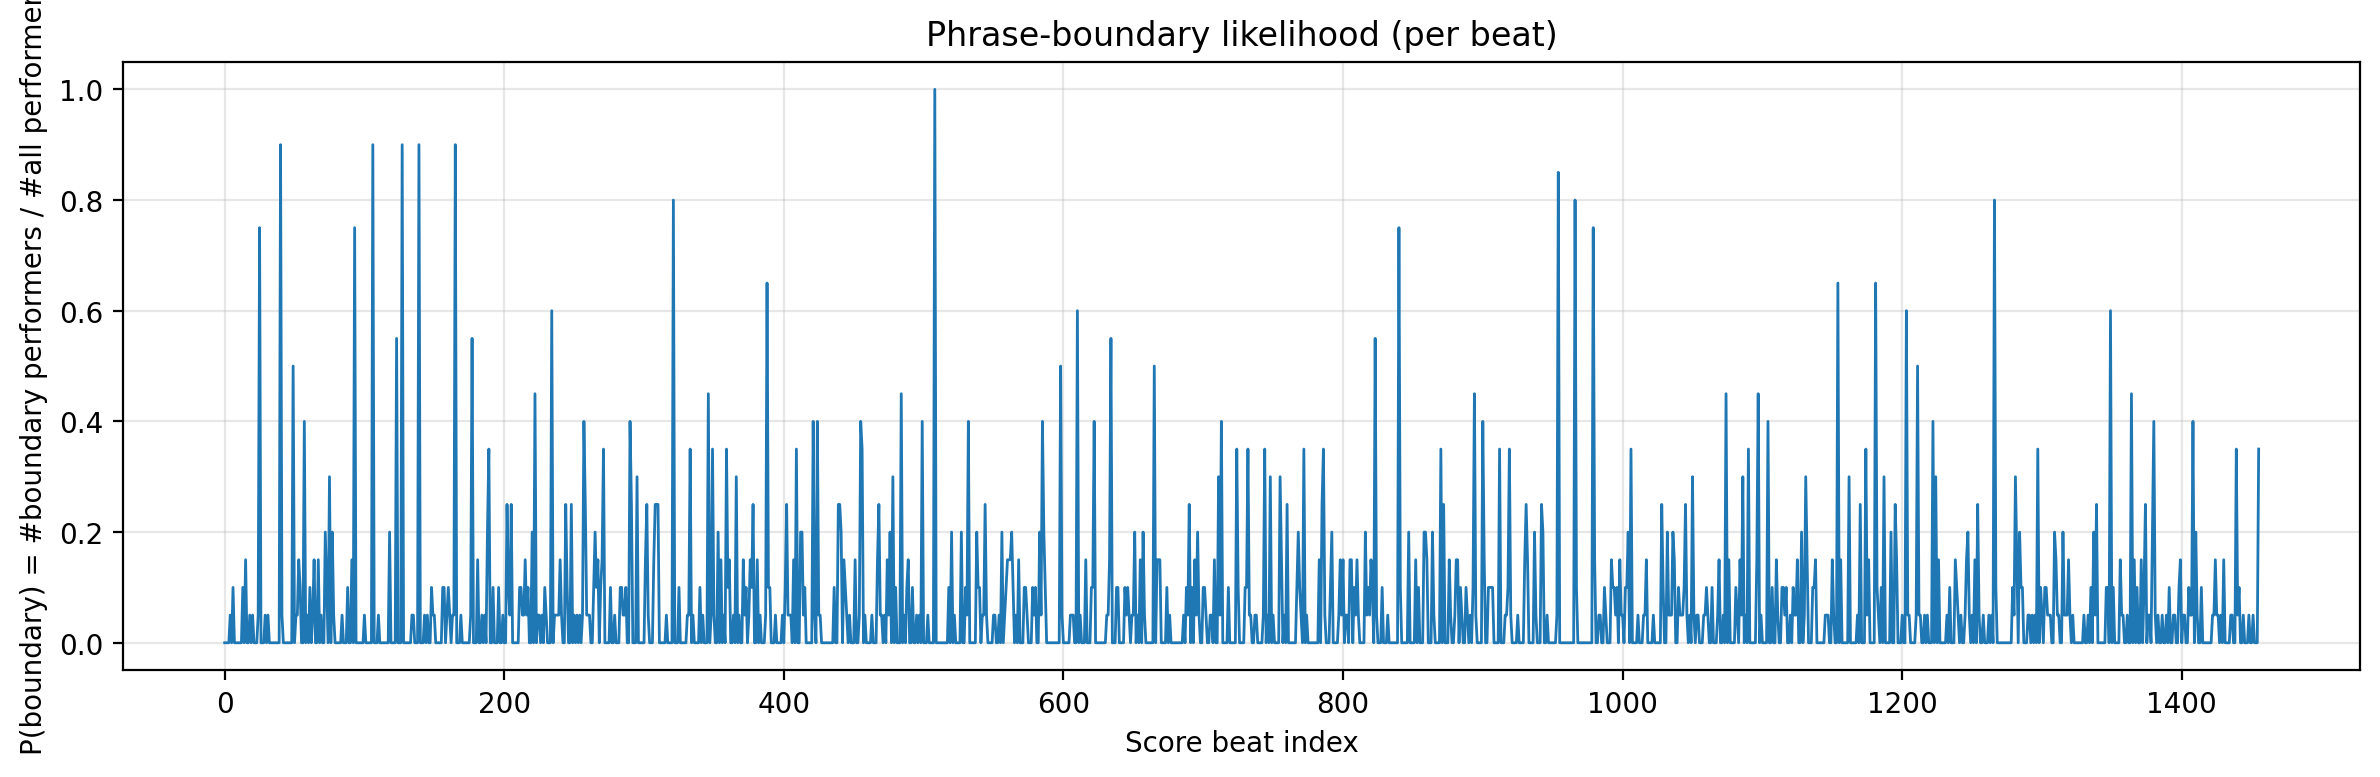

boundary_prob_by_beat shape: (1456,)


In [9]:
# -------------------------
# C) 额外：展示“断句概率曲线”（每个 beat 有多少演奏断句 / 总演奏）
# -------------------------
names = list(tempo_arrays.keys())
n_perfs = len(names)
L = min(len(tempo_arrays[nm]) for nm in names)  # 如果你严格 score-aligned，这里等于 score_total_beats

mask_mat = np.stack([boundary_masks_dict[nm][:L] for nm in names], axis=0)
boundary_counts = mask_mat.sum(axis=0)
boundary_ratio = boundary_counts / n_perfs  # 这就是你要的“每个位置断句概率”

plt.figure(figsize=(12, 4))
plt.plot(np.arange(L), boundary_ratio, linewidth=1)
plt.xlabel("Score beat index")
plt.ylabel("P(boundary) = #boundary performers / #all performers")
plt.title("Phrase-boundary likelihood (per beat)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 存成新数组
boundary_prob_by_beat = boundary_ratio.copy()
print("boundary_prob_by_beat shape:", boundary_prob_by_beat.shape)


In [10]:
import pandas as pd
from pathlib import Path

out_path = Path("boundary_prob_by_beat.csv")
df = pd.DataFrame({
    "beat_index": np.arange(len(boundary_prob_by_beat)),
    "boundary_probability": boundary_prob_by_beat
})
df.to_csv(out_path, index=False)

print("已保存到:", out_path.resolve())

已保存到: /Users/toddywang/Documents/VsCodeProjects/xmltoexp/boundary_prob_by_beat.csv
